In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount("./gdrive")
#!unzip "/content/gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip" -d "./gdrive/My Drive"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
from tqdm import notebook
def Accuracy(Model, Loader):
    Model.to(device)
    preds = []
    g_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(Loader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
          for data in nt:
              img, lbl = data
              img, lbl = img.to(device), lbl.to(device)
              lbl = torch.nn.functional.one_hot(lbl, num_classes=3)*1.0
              lbl[lbl[:, 0]==1 , 2] = 1 

              out = Model(img)
              
              sigm=nn.Sigmoid()
              pred=sigm(out)

              pred[pred <= 0.5] = 0
              pred[pred > 0.5] = 1
              
              total += lbl.size(0)
              correct += ((pred == lbl).all(axis=1)).sum().item()
              preds.append(pred)
              g_truth.append(lbl)
              nt.set_postfix(Accuracy = (correct / total))
    return (correct / total), torch.cat(preds), torch.cat(g_truth)

In [0]:
from sklearn.metrics import multilabel_confusion_matrix
#Following function taken from the repository: https://github.com/Muhammad-Junaid-Ahmad/BSCS17012_COVID19_DLSpring2020 and assignment 4 CV
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    title = 'Confusion Matrix'

    # Compute confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    print('Confusion Matrix')
    
    Ac = [[classes[0]+ "+" +classes[2], classes[1]],
          [classes[1]+ "+" +classes[2], classes[0]],    
          [classes[0]+ "+" +classes[1],classes[2]]]
    
    for cm,classes in zip(mcm, Ac):
        fig, axis = plt.subplots()
        img = axis.imshow(cm, interpolation='nearest', cmap=cmap)
        axis.figure.colorbar(img, ax=axis)
        # We want to show all ticks...
        axis.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(axis.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axis.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        
    return


In [5]:
data_dir='/content/gdrive/My Drive/A_05_Part_02_Dataset'
#Define transforms for the training data and testing data
img_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
#img_transforms = transforms.Compose([transforms.Resize([224, 224]),
 #                                    transforms.ToTensor()])
train_data = datasets.ImageFolder(data_dir + '/Train', transform = img_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test',  transform = img_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform = img_transforms)
#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


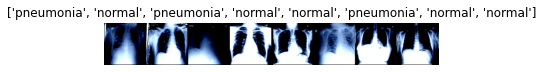

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# **Task 1**

**VGG-16 model**

In [11]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

freezing the layers

In [0]:
# Freeze training for all layers
#for param in vgg16.features.parameters():
#    param.requires_grad = False

Removing the 3 FC layers

In [12]:
num_features = vgg16.classifier[0].in_features
print(num_features)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-7])
print(vgg16)

25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

Adding 2 layers

In [13]:
features = list(vgg16.classifier.children())
print(features)

[]


In [0]:
features.extend([nn.Linear(num_features, (1*10)+100, bias=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.ReLU(inplace=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.Dropout(p=0.5, inplace=False)])
vgg16.classifier = nn.Sequential(*features)


In [0]:
features.extend([nn.Linear((1*10)+100,len(class_names),bias=True)])
vgg16.classifier = nn.Sequential(*features)


In [16]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
def setoutputs(outputs):
  cuda0 = torch.device('cuda:0')
  out=torch.ones(8, dtype=torch.float64, device=cuda0)
  for i in range(outputs.shape[0]):
    out[i]=torch.argmax(outputs[i][:])
  
  return out


In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [44]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
loss_training=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    loss=0.0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(vgg16.state_dict(), 'vgg16_FC_only.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.263847: : 775it [1:21:30,  5.93s/it]


Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.263847: : 775it [1:21:30,  6.31s/it]
Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.160521: : 775it [03:45,  3.43it/s]
Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.160521: : 775it [03:45,  3.43it/s]
Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.058625: : 775it [03:44,  3.46it/s]
Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.076929: : 775it [03:44,  3.45it/s]
Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.068378: : 775it [03:44,  3.45it/s]
Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.002383: : 775it [03:44,  3.45it/s]
Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.030171: : 775it [03:44,  3.46it/s]
Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.009399: : 775it [03:44,  3.46it/s]
Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.000395: : 775it [03:40,  3.51it/s]
Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.020613: : 775it [03:39,  3.53it/s]

Finished Training


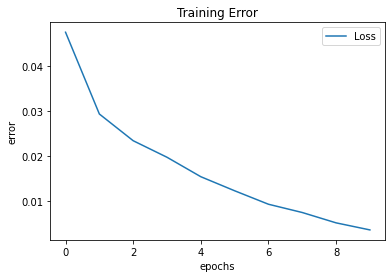

In [45]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#accuracy, predictions, g_Truth = Accuracy(vgg16, testloader)

#print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

#plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

#vgg16.to("cpu")

#torch.cuda.empty_cache()

Accuracy of validation data after fine tuning of FC layers: 54%
Confusion Matrix



Accuracy of Training data after fine tuning of FC layers: 50%
Confusion Matrix


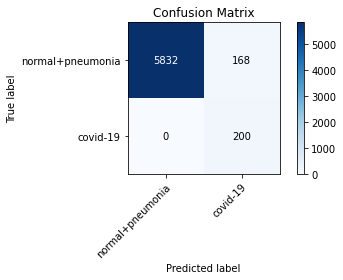

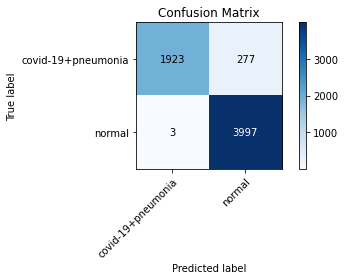

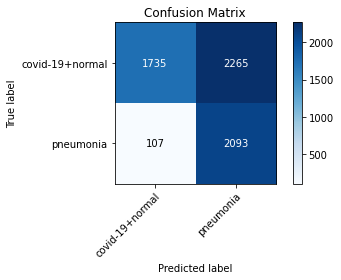

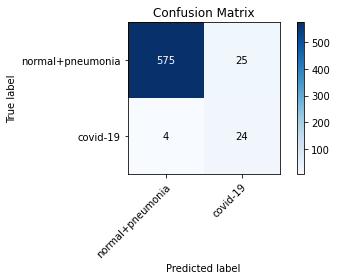

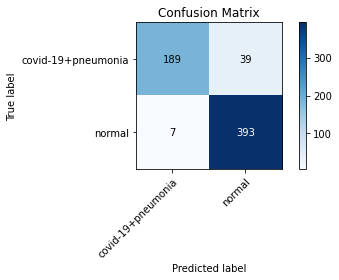

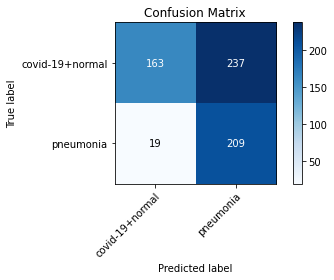

In [69]:
accuracy, predictions, g_Truth = Accuracy(vgg16, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

vgg16.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(vgg16, valloader)

print("Accuracy of Training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

vgg16.to("cpu")

torch.cuda.empty_cache()



**ResNet-18**

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
#print('Output Layer of Resnet-18 : ', resnet18.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
# Freeze training for all layers
#for param in resnet18.parameters():
#    param.requires_grad = False

#for p in resnet18.fc.parameters():
#    p.requires_grad = True

In [0]:
in_features = (resnet18.fc.in_features)
print(in_features)

512


In [0]:
resnet18.fc = nn.Sequential(nn.Linear(in_features, 110), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(110, len(class_names)))


In [0]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00001, momentum=0.9)

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

losst=[]
resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')
    losst.append(running_loss)    
print('Finished Training')

Train Epoch: 0 [11992/12000 (100%)]	Loss: 0.773492: : 1500it [2:11:50,  5.27s/it]
Train Epoch: 1 [11992/12000 (100%)]	Loss: 0.719740: : 1500it [04:21,  5.73it/s]
Train Epoch: 2 [11992/12000 (100%)]	Loss: 0.603545: : 1500it [04:14,  5.88it/s]
Train Epoch: 3 [11992/12000 (100%)]	Loss: 0.463856: : 1500it [04:15,  5.88it/s]
Train Epoch: 4 [11992/12000 (100%)]	Loss: 0.492977: : 1500it [04:16,  5.85it/s]
Train Epoch: 5 [11992/12000 (100%)]	Loss: 0.697370: : 1500it [04:13,  5.91it/s]
Train Epoch: 6 [11992/12000 (100%)]	Loss: 0.480750: : 1500it [04:14,  5.89it/s]
Train Epoch: 7 [11992/12000 (100%)]	Loss: 0.401793: : 1500it [04:23,  5.69it/s]
Train Epoch: 8 [11992/12000 (100%)]	Loss: 0.330406: : 1500it [04:24,  5.68it/s]
Train Epoch: 9 [11992/12000 (100%)]	Loss: 0.160142: : 1500it [04:17,  5.82it/s]


Finished Training


In [0]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
loss_t=[]
for i in range(len(loss_training)):
  loss_t.append(losst[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),loss_t,label="Loss")
plt.legend()
plt.show()


Accuracy after fine tuning of FC layers: 83%
Confusion matrix, without normalization
[[454 161]
 [ 82 803]]


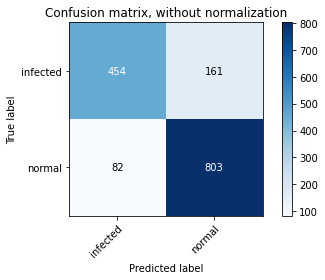

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#accuracy, predictions, g_Truth = Accuracy(resnet18, testloader)

#print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

#plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

#resnet18.to("cpu")

#torch.cuda.empty_cache()

Accuracy of validation data after fine tuning of FC layers: 81%
Confusion matrix, without normalization
[[3496 1423]
 [ 830 6251]]



Accuracy of Training data after fine tuning of FC layers: 78%
Confusion matrix, without normalization
[[419 196]
 [123 762]]


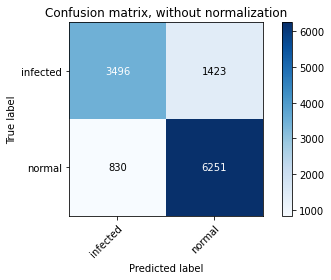

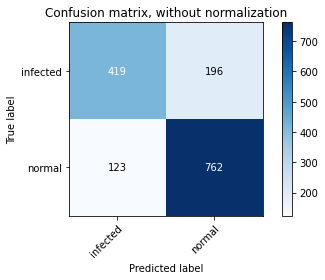

In [0]:
accuracy, predictions, g_Truth = Accuracy(resnet18, trainloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(resnet18, valloader)

print("Accuracy of Training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()


# **Task 2**

**VGG-16 model**

In [22]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

freezing the layers

In [0]:
# Freeze training for all layers
#for param in vgg16.features.parameters():
#    param.requires_grad = False

In [24]:
num_features = vgg16.classifier[0].in_features
print(num_features)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-7])
print(vgg16)

25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [25]:
features = list(vgg16.classifier.children())
print(features)

[]


In [0]:
features.extend([nn.Linear(num_features, (1*10)+100, bias=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.ReLU(inplace=True)])
vgg16.classifier = nn.Sequential(*features)

features.extend([nn.Dropout(p=0.5, inplace=False)])
vgg16.classifier = nn.Sequential(*features)


In [0]:
features.extend([nn.Linear((1*10)+100,len(class_names),bias=True)])
vgg16.classifier = nn.Sequential(*features)


In [28]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
optimizer = optim.SGD(vgg16.parameters(), lr=0.00001, momentum=0.9)

def forward_pass_focal_loss(outputs,targets):
  criterion = nn.BCEWithLogitsLoss(reduction="none")
  loss = criterion(outputs,targets)
  p = torch.exp(-loss)
  lossf = (1-p)**1.5* loss
  loss= torch.sum(lossf)/outputs.shape[0]
  return loss

In [15]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()
loss_training=[]
valacc=[]
trainacc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names))*1.0
        labels[labels[:, 0]==1 , 2] = 1 

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        pred = (torch.sigmoid(outputs.data) >= 0.5) * 1 
        loss = forward_pass_focal_loss(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        #acc, _, __ = Accuracy(vgg16, valloader)
        #valacc.append(acc)
        #acc, _, __ = Accuracy(vgg16, trainloader)
        #trainacc.append(acc)

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [104/6200 (2%)]	Loss: 0.672032: : 14it [01:12,  5.28s/it]

KeyboardInterrupt: ignored

In [0]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
#plt.xlabel('epochs') 
# naming the y axis 
#plt.ylabel('accuracies') 

# giving a title to my graph 
#plt.title('Training Error')

#plt.plot(np.arange(Epochs),trainacc,label="Trainacc")
#plt.plot(np.arange(Epochs),valacc,label="Valacc")
#plt.legend()
#plt.show()


In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#accuracy, predictions, g_Truth = Accuracy(vgg16, testloader)

#print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

#plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

#vgg16.to("cpu")

#torch.cuda.empty_cache()

#vgg16.load_state_dict(torch.load("vgg16_focal_loss.pth"))

<All keys matched successfully>

Accuracy of validation data after fine tuning of FC layers: 89%
Confusion Matrix


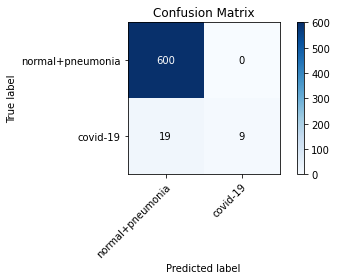

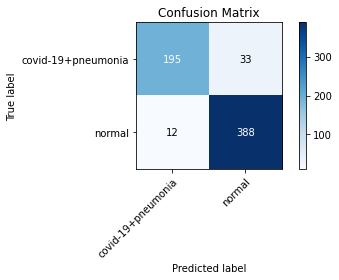

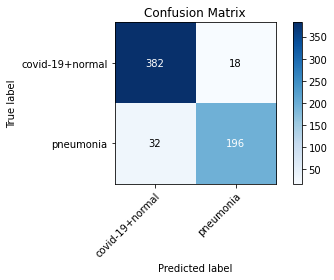

In [30]:
#accuracy, predictions, g_Truth = Accuracy(vgg16, trainloader)

#print("Accuracy of training data after fine tuning of FC layers: %d%%" % (100*accuracy))
#plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

#vgg16.to("cpu")

#torch.cuda.empty_cache()
#print()

accuracy, predictions, g_Truth = Accuracy(vgg16, valloader)

print("Accuracy of validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

vgg16.to("cpu")

torch.cuda.empty_cache()


**Resnet-18**

In [129]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
#print('Output Layer of Resnet-18 : ', resnet18.classifier[6].out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
#for param in resnet18.parameters():
#    param.requires_grad = False

#for p in resnet18.fc.parameters():
#    p.requires_grad = True

In [131]:
in_features = (resnet18.fc.in_features)
print(in_features)

512


In [0]:
resnet18.fc = nn.Sequential(nn.Linear(in_features, 110), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(110, len(class_names)))


In [133]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
optimizer = optim.SGD(resnet18.parameters(), lr=0.00007, momentum=0.9)

def forward_pass_focal_loss(outputs,targets):
  criterion = nn.BCEWithLogitsLoss(reduction="none")
  loss = criterion(outputs,targets)
  p = torch.exp(-loss)
  lossf = (1-p)**1.5* loss
  loss= torch.sum(lossf)/outputs.shape[0]
  return loss

In [135]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()
loss_training=[]
valacc=[]
trainacc=[]

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), position=0, leave=True)
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names))*1.0
        labels[labels[:, 0]==1 , 2] = 1 

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        pred = (torch.sigmoid(outputs.data) >= 0.5) * 1 
        loss = forward_pass_focal_loss(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        #acc, _, __ = Accuracy(vgg16, valloader)
        #valacc.append(acc)
        #acc, _, __ = Accuracy(vgg16, trainloader)
        #trainacc.append(acc)

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                (loss.data)))
      
    torch.save(resnet18.state_dict(), 'resnet18_focal_loss.pth')
    loss_training.append(running_loss)

print('Finished Training')

Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.598181: : 775it [02:37,  4.92it/s]
Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.335440: : 775it [02:35,  5.00it/s]
Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.474386: : 775it [02:35,  4.99it/s]
Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.136017: : 775it [02:35,  5.00it/s]
Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.308943: : 775it [02:34,  5.00it/s]
Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.296422: : 775it [02:34,  5.01it/s]
Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.097036: : 775it [02:34,  5.01it/s]
Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.226531: : 775it [02:34,  5.01it/s]
Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.132431: : 775it [02:35,  5.00it/s]
Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.068902: : 775it [02:34,  5.02it/s]


Finished Training


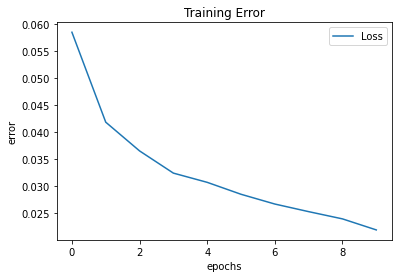

In [139]:
#plot graph of training loss
import matplotlib.pyplot as plt
%matplotlib inline

#print(len(inputs))
losst=[]
for i in range(len(loss_training)):
  losst.append(loss_training[i]/len(trainloader.dataset))

# naming the x axis 
plt.xlabel('epochs') 
# naming the y axis 
plt.ylabel('error') 

# giving a title to my graph 
plt.title('Training Error')

plt.plot(np.arange(Epochs),losst,label="Loss")
plt.legend()
plt.show()


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#accuracy, predictions, g_Truth = Accuracy(resnet18, testloader)

#print("Accuracy after fine tuning of FC layers: %d%%" % (100*accuracy))

#plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

#resnet18.to("cpu")

#torch.cuda.empty_cache()

Accuracy of Training data after fine tuning of FC layers: 89%
Confusion Matrix



Accuracy of Validation data after fine tuning of FC layers: 86%
Confusion Matrix


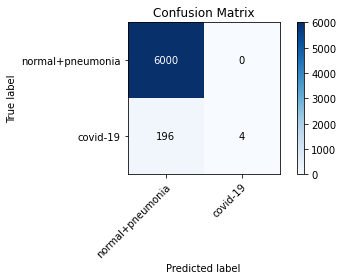

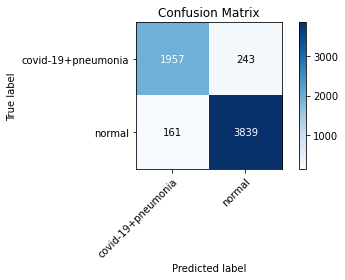

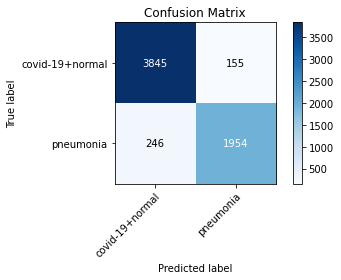

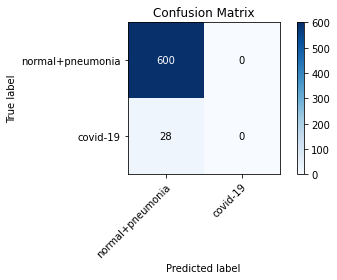

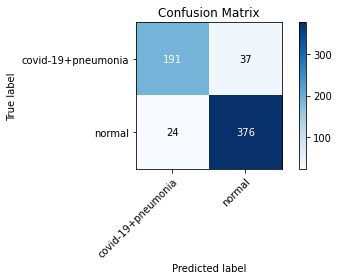

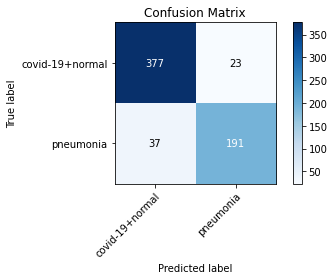

In [141]:
accuracy, predictions, g_Truth = Accuracy(resnet18, trainloader)

print("Accuracy of Training data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")

torch.cuda.empty_cache()
print()

accuracy, predictions, g_Truth = Accuracy(resnet18, valloader)

print("Accuracy of Validation data after fine tuning of FC layers: %d%%" % (100*accuracy))
plot_confusion_matrix(g_Truth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)



resnet18.to("cpu")

torch.cuda.empty_cache()


Saving the csv


In [51]:
i_name=[]
with torch.no_grad():
    for i in range(testloader.sampler.num_samples):
        sample_fname, _ = testloader.dataset.samples[i]
        i_name.append("{}\n".format(sample_fname[56:]))
print(i_name)
print(len(i_name))

['0.png\n', '1.png\n', '10.png\n', '100.png\n', '101.png\n', '102.png\n', '103.png\n', '104.jpg\n', '105.jpg\n', '106.png\n', '107.png\n', '108.png\n', '109.png\n', '11.png\n', '110.png\n', '111.png\n', '112.png\n', '113.png\n', '114.png\n', '115.png\n', '116.png\n', '117.png\n', '118.png\n', '119.png\n', '12.png\n', '120.png\n', '121.png\n', '122.png\n', '123.png\n', '124.png\n', '125.png\n', '126.png\n', '127.png\n', '128.png\n', '129.png\n', '13.png\n', '130.png\n', '131.png\n', '132.png\n', '133.png\n', '134.png\n', '135.png\n', '136.png\n', '137.png\n', '138.png\n', '139.png\n', '14.png\n', '140.png\n', '141.png\n', '142.png\n', '143.png\n', '144.png\n', '145.png\n', '146.png\n', '147.png\n', '148.png\n', '149.jpg\n', '15.png\n', '150.png\n', '151.png\n', '152.png\n', '153.png\n', '154.png\n', '155.png\n', '156.png\n', '157.png\n', '158.png\n', '159.png\n', '16.png\n', '160.png\n', '161.png\n', '162.png\n', '163.png\n', '164.png\n', '165.png\n', '166.png\n', '167.png\n', '168.png\

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

total=0
correct=0
preds=[]
with torch.no_grad():
  with notebook.tqdm(testloader , leave=False, desc="Predicting ", mininterval=0.5 ) as nt:
    for data in nt:
        img, lbl = data
        img, lbl = img.to(device), lbl.to(device)
        lbl = torch.nn.functional.one_hot(lbl, num_classes=3)*1.0
        
        lbl[lbl[:, 0]==1 , 2] = 1 

        out = vgg16(img)
        
        sigm=nn.Sigmoid()
        pred=sigm(out)

        pred[pred > 0.5] = 1
        pred[pred <= 0.5] = 0
        total += lbl.size(0)
        correct += ((pred == lbl).all(axis=1)).sum().item()
        preds.append(pred)
        
        
        out=torch.cat(preds)

In [53]:
print(out)

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0')


In [61]:
import pandas as pd

print(len(i_name))
out = out.to("cpu")
data = {"Image Names":i_name[:], "COVID-19":out[:,0], "Pneumonia":out[:,2], "Normal":out[:,1] }
data = pd.DataFrame.from_dict(data)
data.to_csv("BSCS17001_result.csv", index=False)
data

629


,Image Names,COVID-19,Pneumonia,Normal
0,0.png\n,0.0,0.0,1.0
1,1.png\n,0.0,0.0,1.0
2,10.png\n,0.0,0.0,1.0
3,100.png\n,0.0,0.0,1.0
4,101.png\n,0.0,0.0,1.0
...,...,...,...,...
624,95.png\n,0.0,0.0,1.0
625,96.png\n,1.0,1.0,0.0
626,97.png\n,0.0,0.0,1.0
627,98.png\n,0.0,0.0,1.0
